<a href="https://colab.research.google.com/github/kSahatova/ITMO_MLTech/blob/main/Lab3/MLTech_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression as a Neural Network 
(partly following deeplearning.ai lab)

    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 


In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/bioresponse.csv')
features = data.iloc[:,1:]
labels = data.iloc[:,0]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=9)

In [5]:
X_train = np.asarray(X_train).T
X_test = np.asarray(X_test).T
y_train = np.asarray(y_train).reshape(1, -1)
y_test = np.asarray(y_test).reshape(1, -1)

In [6]:
print('Shape of train set features: ', X_train.shape)
print('Shape of test set features: ', X_test.shape)
print('Shape of train set labels: ', y_train.shape)
print('Shape of test set labels: ', y_test.shape)

Shape of train set features:  (1776, 2813)
Shape of test set features:  (1776, 938)
Shape of train set labels:  (1, 2813)
Shape of test set labels:  (1, 938)


## General Architecture of the algorithm ##


Build a Logistic Regression, using a Neural Network mindset.

**Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

**Key steps**:
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## Parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features, number of layers, number of neurons in the layer etc.) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

Build 1-3 separately and integrate them into one function we call `model()`.

### Sigmoid

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 

In [7]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

### Initializing parameters



In [8]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

### Forward and Backward propagation

Implement a function `propagate()` that computes the cost function and its gradient.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we should use: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [30]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
   
    m = X.shape[1]

  
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1) # compute cost   


    # BACKWARD PROPAGATION (TO FIND GRAD) 
    
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y)
    

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Optimization
- We have initialized the parameters.
- We are able to compute a cost function and its gradient.
- Now, we have to update the parameters using gradient descent.

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [71]:
# optimize

def optimize(w, b, X, Y, num_iterations, learning_rate,optimizer, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    b1 = 0.9
    b2 = 0.999
    epsilon = 1e-8
    m_w = 0
    m_b = 0
    v_w = 0
    v_b = 0
    
    for i in range(num_iterations):
        
        if optimizer == 'SGD':
          m = X.shape[1]
          sample_num = random.randint(0, m-1) 
          X_ = X[:, sample_num].reshape(-1, 1)
          Y_ = Y[:, sample_num].reshape(-1, 1)      
          grads, cost = propagate(w,b,X_,Y_)
        
        elif optimizer == 'Adam':
          m = X.shape[1]
                    
          # Compute gradients
          grads, cost = propagate(w, b, X, Y)

          dw = grads['dw']
          db = grads['db']

          # Update rule for w
          m_w = b1 * m_w + (1 - b1) * dw
          v_w = b2 * v_w + (1 - b2) * (dw**2)
          
          m_wc = m_w/(1 - b1**(i+1))
          v_wc = v_w/(1 - b2**(i+1))          
          
          w = w - learning_rate * (m_wc/(v_wc**(1/2) + epsilon))

          # Update rule for b
          m_b = b1 * m_b + (1 - b1) * db
          v_b = b2 * v_b + (1 - b2) * (db**2)
          
          m_bc = m_b/(1 - b1**(i+1))
          v_bc = v_b/(1 - b2**(i+1))
          
          b = b - learning_rate * (m_bc/(v_bc**(1/2) + epsilon))

        else:
        # Cost and gradient calculation 
          grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

Implement the `predict()` function. There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`. 

In [35]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    
    # Compute vector "A" predicting the probabilities 
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

In [ ]:
print ("predictions = " + str(predict(params['w'], params['b'], X_test)))


Already have:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## Merge it all into a model ##

    - Y_prediction_test for the predictions on the test set
    - Y_prediction_train for the predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [12]:
# model

def model(X_train, Y_train, X_test, Y_test, optimizer, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, optimizer, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [56]:
def plot_learning_curve(costs, num_iterations, label='GD'):
  x = [i for i in range(1, num_iterations+1) if i%100 == 0]
  plt.figure(figsize=(5, 5))
  plt.plot(x, costs, label=label)
  plt.xlabel('Number of iterations')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

## Gradient Descent

In [13]:
learn_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
models_gd = []
models_sgd = []

In [36]:
for learn_rate in learn_rates:
  print(f'\nModel optimized with GD with learning rate = {learn_rate}')
  output_gd = model(X_train, y_train, X_test, y_test, optimizer='GD', num_iterations=2000, learning_rate=learn_rate, print_cost=False)
  models_gd.append(output_gd)


Model optimized with GD with learning rate = 0.001
train accuracy: 72.48489157483114 %
test accuracy: 68.44349680170575 %

Model optimized with GD with learning rate = 0.005
train accuracy: 77.92392463562034 %
test accuracy: 74.30703624733476 %

Model optimized with GD with learning rate = 0.01
train accuracy: 79.16814788482047 %
test accuracy: 74.84008528784648 %

Model optimized with GD with learning rate = 0.05
train accuracy: 82.50977603981514 %
test accuracy: 75.26652452025587 %

Model optimized with GD with learning rate = 0.1
train accuracy: 83.96729470316389 %
test accuracy: 74.94669509594883 %


Increment of the lerning rate for model optimization with gradient descent leads to the growth of the accuracy on the training and test sets.

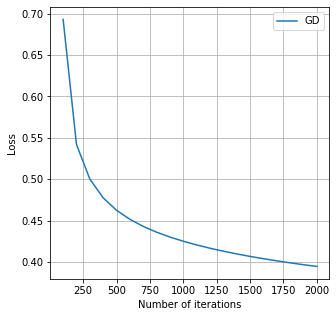

In [57]:
plot_learning_curve(models_gd[4]['costs'],2000)

## Stochastic Gradient Descent

In [42]:
for learn_rate in learn_rates:
  print(f'\nModel optimized with SGD with learning rate = {learn_rate}')
  output_sgd = model(X_train, y_train, X_test, y_test, optimizer='SGD', num_iterations=2000, learning_rate=learn_rate, print_cost=False)
  models_sgd.append(output_sgd)


Model optimized with SGD with learning rate = 0.001
train accuracy: 69.32100959829364 %
test accuracy: 65.77825159914713 %

Model optimized with SGD with learning rate = 0.005
train accuracy: 76.57305367934589 %
test accuracy: 72.38805970149254 %

Model optimized with SGD with learning rate = 0.01
train accuracy: 75.7198720227515 %
test accuracy: 71.64179104477611 %

Model optimized with SGD with learning rate = 0.05
train accuracy: 75.54212584429435 %
test accuracy: 69.7228144989339 %

Model optimized with SGD with learning rate = 0.1
train accuracy: 71.41841450408816 %
test accuracy: 66.63113006396588 %


Unlike the optimization with GD, stochastic gradient descent gets its optimal accuracy with a learning rate equals 0.005.

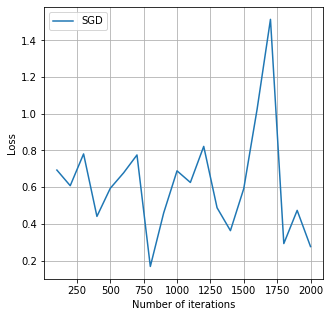

In [58]:
plot_learning_curve(models_sgd[1]['costs'], 2000, label='SGD')

## Adam optimizer

In [74]:
print(f'\nModel optimized with ADAM with learning rate = {0.001}')
model_adam = model(X_train, y_train, X_test, y_test, optimizer='Adam', num_iterations=2000, learning_rate=0.001, print_cost=False)


Model optimized with ADAM with learning rate = 0.001
train accuracy: 89.79736935655883 %
test accuracy: 75.15991471215352 %


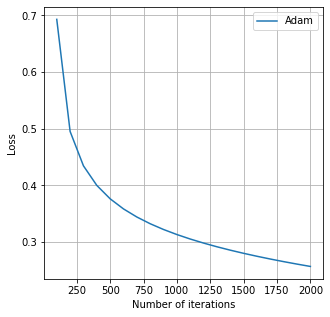

In [73]:
plot_learning_curve(model_adam['costs'], 2000, label='Adam')

Implementation of the Adam optimizer helped to reach the best accuracy on the training and test sets using first and second moments.

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
